# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

12:19:10 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=433579;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=362332;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=168027;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=610338;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

12:20:07 INFO      Auto-determined polynomial order: 0                                ]8;id=61805;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=173040;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

12:20:24 INFO      None 0-order polynomial fit with the mle method                               ]8;id=71633;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=966794;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=561112;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=865522;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=867952;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=779220;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

12:20:25 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=231430;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=408358;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=606991;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=99089;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=861643;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=398202;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=706266;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=131132;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=280176;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=852826;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=229540;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=617081;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

12:20:28 INFO      Now using 120 bins                                                          ]8;id=510101;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=371800;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

12:20:30 INFO      Auto-determined polynomial order: 1                                ]8;id=565813;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=49734;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

12:20:48 INFO      None 1-order polynomial fit with the mle method                               ]8;id=409503;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=524806;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=969035;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=325165;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=697050;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=56789;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

12:20:49 INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=882322;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=565689;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=302592;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=538644;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=942773;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=34380;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=518448;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=44273;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=232499;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=237156;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=673108;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=446612;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=364572;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=697260;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

12:20:51 INFO      Auto-determined polynomial order: 1                                ]8;id=162282;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=959593;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

12:21:09 INFO      None 1-order polynomial fit with the mle method                               ]8;id=921872;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=587415;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=302136;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=266023;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=172784;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=759196;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

12:21:10 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=995909;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=104627;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=999554;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=328758;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=52666;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=631970;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=730873;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=406765;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=594750;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=94390;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=934267;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=150814;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=839254;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=28942;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

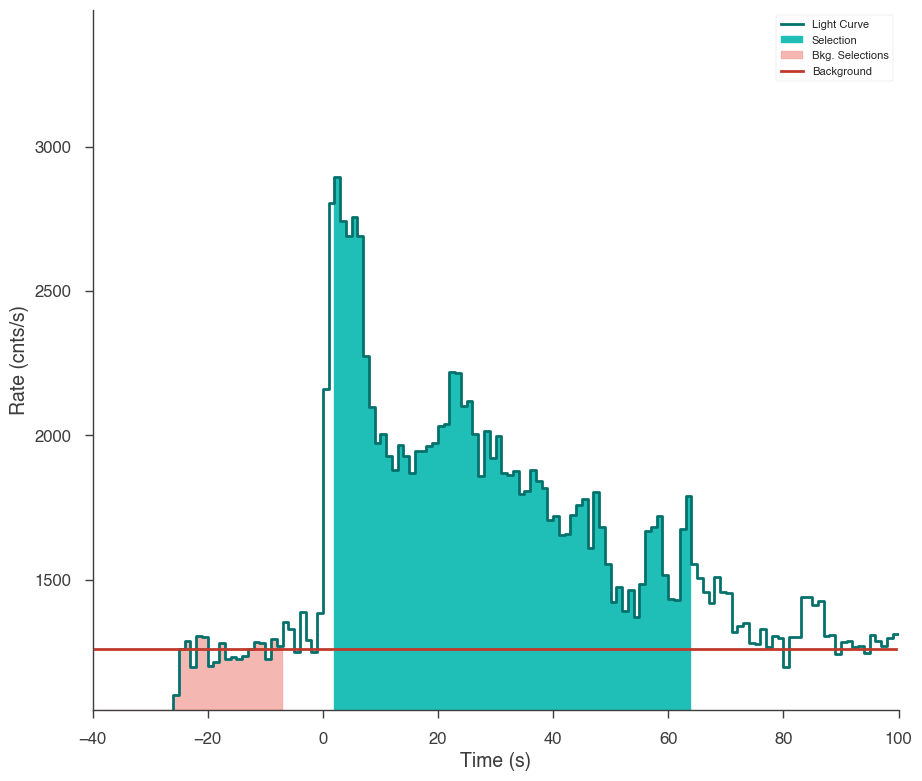

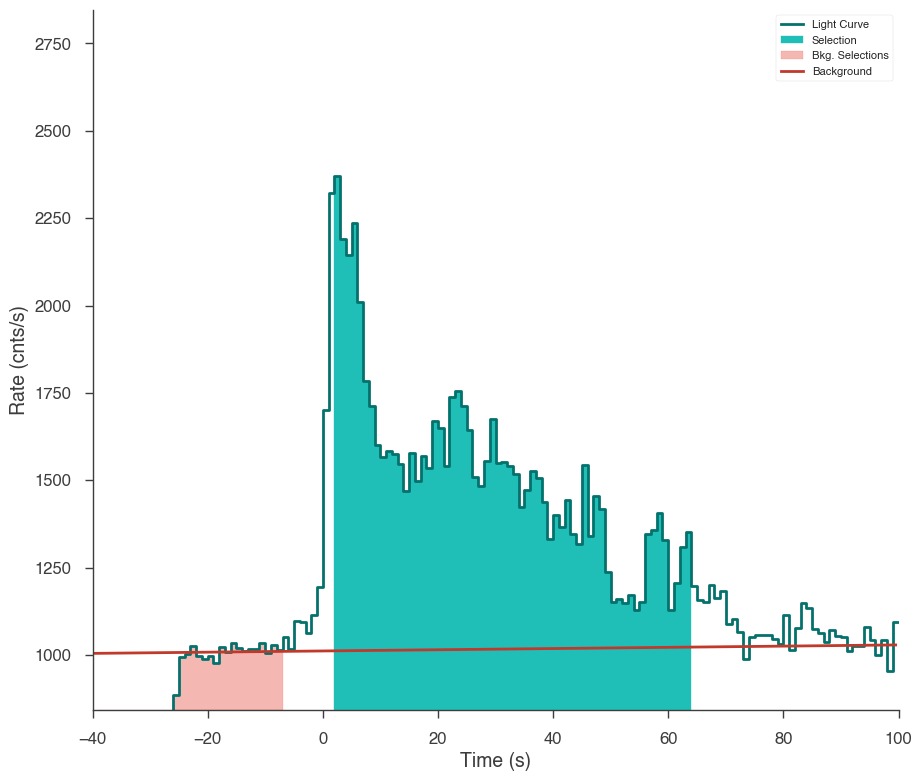

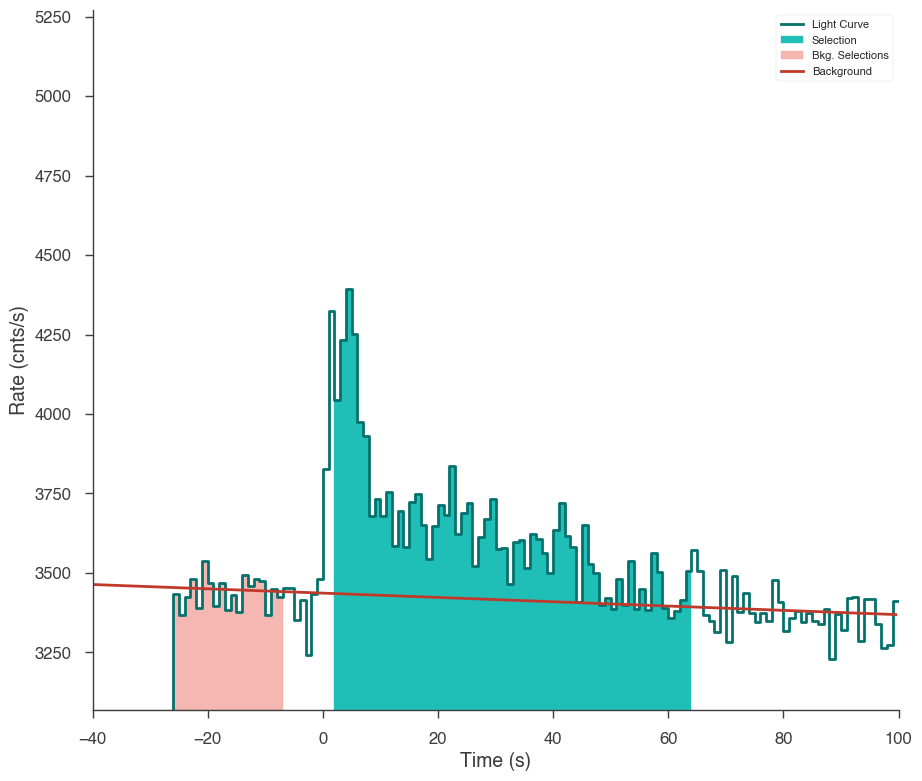

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

12:21:11 INFO      sampler set to multinest                                                ]8;id=850230;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=979232;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

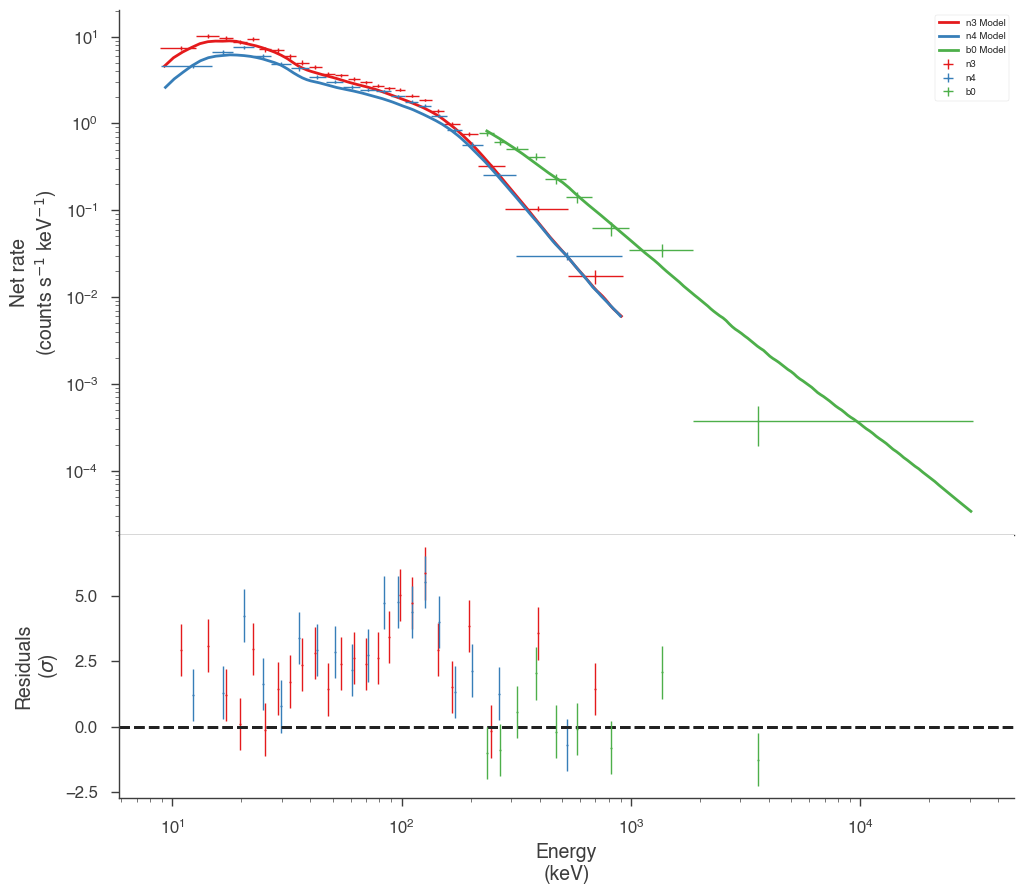

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3101.6252541183744      +/-  0.22696556052769751     
 Total Likelihood Evaluations:        22238
 Sampling finished. Exiting MultiNest



12:21:36 INFO      fit restored to maximum of posterior                                         ]8;id=863075;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=901360;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=996479;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=384985;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
GRB080916009...K             (1.464 -0.013 +0.024) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha                  -1.082 -0.013 +0.021                 
GRB080916009...break_energy       (1.90 +0.08 +0.6) x 10^2              keV
GRB080916009...break_scale         (0.0 +1.6 +3.1) x 10^-1                 
GRB080916009...beta                    -1.984 -0.16 -0.012

Values of -log(posterior) at the minimum:

-log(posterior)
b0        -1049.421426
n3        -1019.541149
n4        -1010.677014
total     -3079.639589

Values of statistical measures:

statistical measures
AIC              6169.449633
BIC              6188.681844
DIC              6178.824313
PDIC                3.951179
log(Z)          -1347.018733

Now our model seems to match much better with the data!

12:21:37 INFO      fit restored to median of posterior                                          ]8;id=786127;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=942911;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

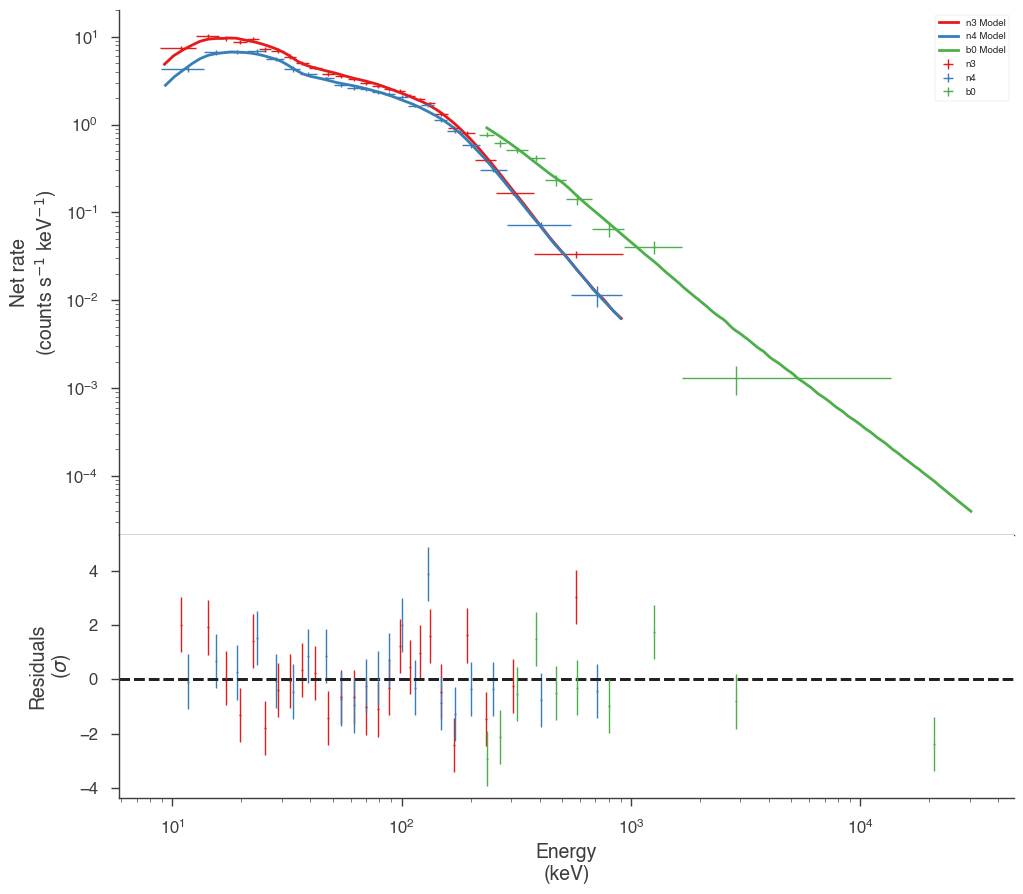

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

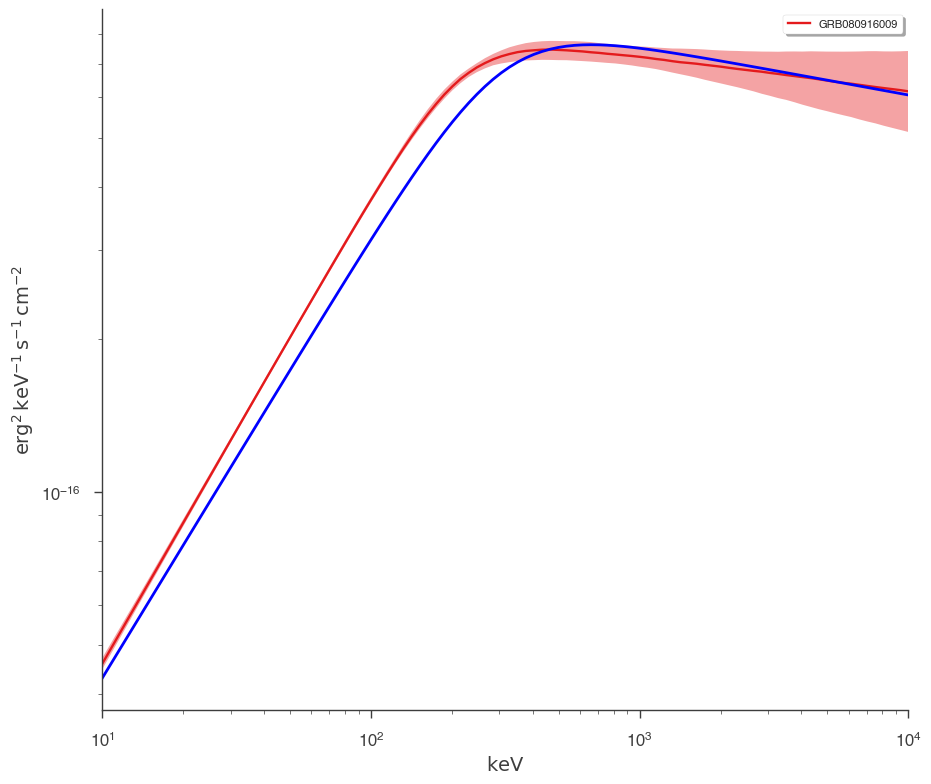

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

12:23:38 INFO      Created 15 bins via bayesblocks                                       ]8;id=591136;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=904387;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


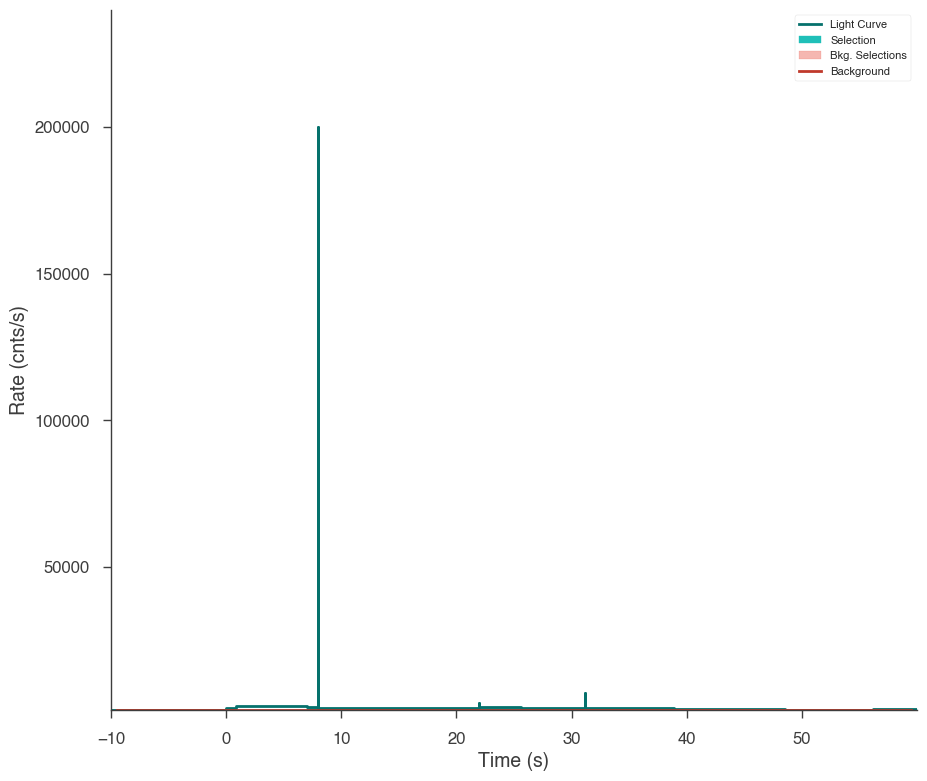

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

12:23:39 INFO      Created 12 bins via custom                                            ]8;id=402992;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=972343;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

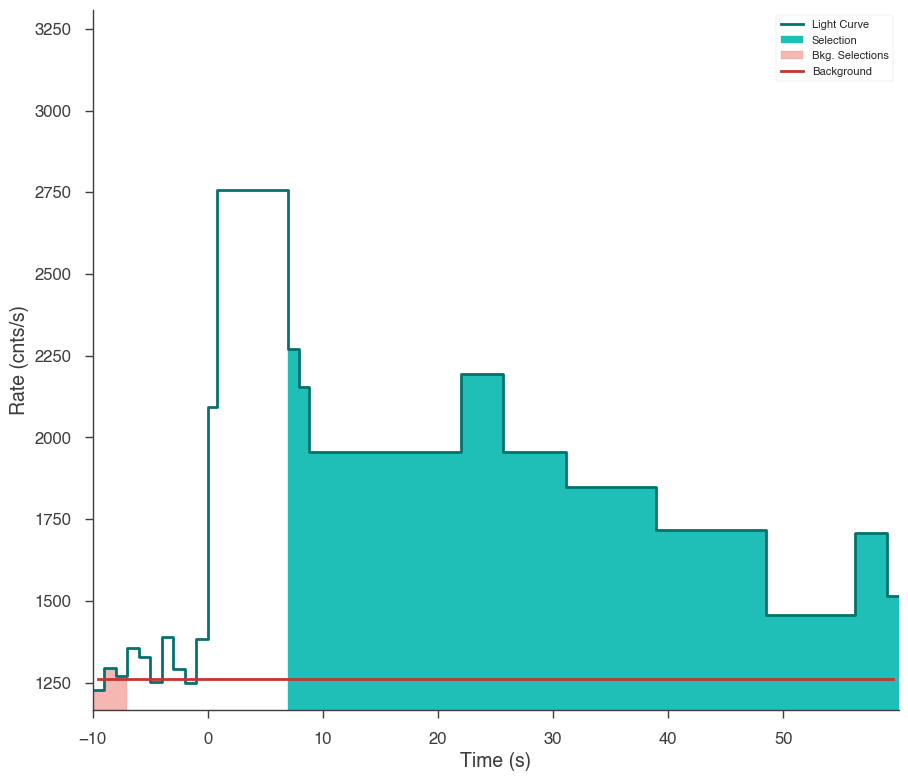

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=249751;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=141851;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

12:23:40 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=411018;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=579830;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=767486;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=184589;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=423274;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=49728;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=27002;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=748792;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

12:23:41 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=154834;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=935833;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=702767;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=478286;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=105239;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=979237;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=16;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=687668;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=271360;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=731649;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=789102;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=329356;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 107 bins                                                          ]8;id=234298;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=226593;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=935798;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=923950;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -788.70466625672896      +/-  0.17980896350242567     
 Total Likelihood Evaluations:        16619
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


12:23:58 INFO      fit restored to maximum of posterior                                         ]8;id=590132;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=814512;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=566906;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=423737;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (3.6 -0.7 +0.4) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-5.6 -1.6 +0.7) x 10^-1                 
grb.spectrum.main.Band.xp     (3.13 -0.32 +1.0) x 10^2              keV
grb.spectrum.main.Band.beta           -2.07 -0.4 +0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval0      -285.663331
n3_interval0      -250.120519
n4_interval0      -268.016019
total             -803.799869

Values of statistical measures:

statistical measures
AIC              1615.713052
BIC              1631.121870
DIC              1569.973094
PDIC                2.222449
log(Z)           -342.530084

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=350168;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=218865;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=774339;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=169919;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=108001;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=127966;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=753589;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=193757;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=842149;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=504784;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=347666;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=440873;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=355320;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=278978;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1996.9414600674347      +/-  0.22125179480860935     
 Total Likelihood Evaluations:        23112
 Sampling finished. Exiting MultiNest



12:24:22 INFO      fit restored to maximum of posterior                                         ]8;id=612836;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=477126;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=843843;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=275029;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K      (6.901 +0.008 +0.17) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-5.10 -0.05 +0.22) x 10^-1                 
grb.spectrum.main.Band.xp      (2.626 -0.08 +0.005) x 10^2              keV
grb.spectrum.main.Band.beta           -1.757 -0.006 +0.015

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval1      -694.781057
n3_interval1      -656.126869
n4_interval1      -651.227341
total            -2002.135267

Values of statistical measures:

statistical measures
AIC              4012.383848
BIC              4027.792666
DIC              3968.635295
PDIC                2.141112
log(Z)           -867.260657

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=572103;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=143219;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=242807;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=232104;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=259088;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=917383;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=321370;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=339522;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=620393;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=406035;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 115 bins                                                          ]8;id=373641;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=605487;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=124286;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=940958;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -914.07697907054410      +/-  0.19684489017743562     
 Total Likelihood Evaluations:        17275
 Sampling finished. Exiting MultiNest



12:24:44 INFO      fit restored to maximum of posterior                                         ]8;id=745695;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=440263;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=748113;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=739175;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K         (3.53 +0.14 +0.5) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.407 -0.011 +0.7) x 10^-1                 
grb.spectrum.main.Band.xp         (2.81 -0.5 -0.04) x 10^2              keV
grb.spectrum.main.Band.beta            -1.762 -0.031 +0.04

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval2      -322.880793
n3_interval2      -288.381517
n4_interval2      -311.168661
total             -922.430971

Values of statistical measures:

statistical measures
AIC              1852.975256
BIC              1868.384074
DIC              1809.913983
PDIC                1.259639
log(Z)           -396.978588

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=637058;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=891769;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=265404;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=858383;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=735304;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=978178;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=44586;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=976733;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=663742;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=375140;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 109 bins                                                          ]8;id=535462;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=788574;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=534355;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=92748;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.46456707742811      +/-  0.17695882427049806     
 Total Likelihood Evaluations:        17888
 Sampling finished. Exiting MultiNest



12:25:01 INFO      fit restored to maximum of posterior                                         ]8;id=478902;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=582205;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=500817;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=81628;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (2.87 -0.20 +0.5) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-9.3 -0.5 +1.1) x 10^-1                 
grb.spectrum.main.Band.xp        (3.4 -0.7 +0.5) x 10^2              keV
grb.spectrum.main.Band.beta           -2.21 -0.30 +0.17

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval3      -298.430554
n3_interval3      -242.517902
n4_interval3      -262.535430
total             -803.483886

Values of statistical measures:

statistical measures
AIC              1615.081087
BIC              1630.489905
DIC              1569.772292
PDIC                2.687647
log(Z)           -342.425811

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=966786;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=125642;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=769372;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=879200;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=465225;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=960331;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=757617;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=60590;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=301606;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=727031;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=740042;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=277318;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=996339;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=693023;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2270.7605085090718      +/-  0.19888839240627920     
 Total Likelihood Evaluations:        21041
 Sampling finished. Exiting MultiNest



12:25:21 INFO      fit restored to maximum of posterior                                         ]8;id=55264;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=257276;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=499045;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=327076;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.07 -0.13 +0.08) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-9.72 -0.5 +0.25) x 10^-1                 
grb.spectrum.main.Band.xp       (3.92 -0.30 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta          -1.944 -0.15 +0.032

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval4      -778.506290
n3_interval4      -757.165311
n4_interval4      -746.560900
total            -2282.232501

Values of statistical measures:

statistical measures
AIC              4572.578316
BIC              4587.987133
DIC              4527.476892
PDIC                3.226678
log(Z)           -986.178759

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=596411;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=723522;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=304426;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=114902;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=285961;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=488507;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=512487;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=738381;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=160691;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=719195;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=681550;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=730003;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=231064;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=506934;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1575.0062385311087      +/-  0.20203880324121185     
 Total Likelihood Evaluations:        19555
 Sampling finished. Exiting MultiNest



12:25:41 INFO      fit restored to maximum of posterior                                         ]8;id=989805;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=760648;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=142621;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=259092;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.75 -0.15 +0.09) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-9.12 -0.5 +0.22) x 10^-1                 
grb.spectrum.main.Band.xp       (4.44 -0.24 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta          -2.337 -0.14 -0.021

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval5      -537.582307
n3_interval5      -524.288713
n4_interval5      -527.726865
total            -1589.597886

Values of statistical measures:

statistical measures
AIC              3187.309087
BIC              3202.717904
DIC              3136.311165
PDIC                2.301455
log(Z)           -684.016518

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=7486;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=259702;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=611793;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=674190;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=737886;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=240939;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=47783;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=775680;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=819346;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=18847;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=7486;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=588521;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=830967;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=519957;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1756.4934951292819      +/-  0.19700894770398927     
 Total Likelihood Evaluations:        19407
 Sampling finished. Exiting MultiNest



12:26:03 INFO      fit restored to maximum of posterior                                         ]8;id=398306;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=192845;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=542196;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=764562;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K      (1.955 +0.026 +0.20) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.002 +0.010 +0.06                 
grb.spectrum.main.Band.xp       (4.557 -0.8 -0.029) x 10^2              keV
grb.spectrum.main.Band.beta            -2.334 -0.35 -0.014

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval6      -609.848369
n3_interval6      -584.149641
n4_interval6      -576.980714
total            -1770.978724

Values of statistical measures:

statistical measures
AIC              3550.070762
BIC              3565.479580
DIC              3499.425837
PDIC                1.821114
log(Z)           -762.835432

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=47651;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=50964;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=118280;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=958453;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=501817;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=338912;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=404343;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=589008;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=937814;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=594831;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=677963;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=19908;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=408630;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=202178;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1938.8010805458339      +/-  0.18778846968729640     
 Total Likelihood Evaluations:        20730
 Sampling finished. Exiting MultiNest



12:26:22 INFO      fit restored to maximum of posterior                                         ]8;id=461762;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=418004;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=66437;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=240873;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.65 -0.07 +0.17) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.04 -0.04 +0.06                 
grb.spectrum.main.Band.xp         (4.4 -0.8 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta             -2.24 -0.5 +0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval7      -662.441228
n3_interval7      -640.407324
n4_interval7      -650.979550
total            -1953.828102

Values of statistical measures:

statistical measures
AIC              3915.769519
BIC              3931.178336
DIC              3869.366395
PDIC                3.318642
log(Z)           -842.010611

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=66709;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=433045;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=61560;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=52470;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=52629;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=34861;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=106427;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=604487;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=378935;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=171959;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=840177;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=587619;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=729053;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=637132;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2053.5810211334874      +/-  0.18543416667418725     
 Total Likelihood Evaluations:        20520
 Sampling finished. Exiting MultiNest



12:26:41 INFO      fit restored to maximum of posterior                                         ]8;id=988445;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=994232;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=285318;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=918018;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.56 -0.15 +0.09) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-8.4 -0.7 +0.5) x 10^-1                 
grb.spectrum.main.Band.xp       (3.65 -0.26 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta             -2.25 -0.4 +0.08

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval8      -702.094101
n3_interval8      -698.420884
n4_interval8      -665.967101
total            -2066.482086

Values of statistical measures:

statistical measures
AIC              4141.077486
BIC              4156.486304
DIC              4098.351046
PDIC                3.373994
log(Z)           -891.858906

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=935127;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=310412;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=427801;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=842884;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=26381;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=172504;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=795754;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=811495;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=426492;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=951332;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=17584;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=941693;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=316163;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=747854;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1879.5786676077348      +/-  0.14836645062747578     
 Total Likelihood Evaluations:        13371
 Sampling finished. Exiting MultiNest



12:26:54 INFO      fit restored to maximum of posterior                                         ]8;id=626631;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=841670;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=400954;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=508723;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (1.03 -0.08 +3.0) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-8.9 -0.5 +5) x 10^-1                 
grb.spectrum.main.Band.xp      (1.20 -0.6 +0.13) x 10^2              keV
grb.spectrum.main.Band.beta           -1.93 -0.11 +0.26

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval9      -648.194868
n3_interval9      -617.159826
n4_interval9      -616.521717
total            -1881.876411

Values of statistical measures:

statistical measures
AIC              3771.866137
BIC              3787.274955
DIC              3664.925983
PDIC              -82.212611
log(Z)           -816.290644

12:26:55 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=777683;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=855455;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=103087;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=828465;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=492389;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=763251;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=307661;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=951185;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=303182;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=117260;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=983692;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=190457;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=606365;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=825362;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1324.9301648285586      +/-  0.18142059550384146     
 Total Likelihood Evaluations:        18691
 Sampling finished. Exiting MultiNest



12:27:15 INFO      fit restored to maximum of posterior                                         ]8;id=268082;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=64015;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=828503;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=700683;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K       (2.00 +0.05 +1.0) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-7.20 +0.24 +2.2) x 10^-1                 
grb.spectrum.main.Band.xp       (2.41 -0.6 -0.05) x 10^2              keV
grb.spectrum.main.Band.beta            -2.19 -0.05 +0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval10      -460.957928
n3_interval10      -438.110085
n4_interval10      -434.228180
total             -1333.296193

Values of statistical measures:

statistical measures
AIC              2674.705701
BIC              2690.114518
DIC              2634.124796
PDIC                0.202190
log(Z)           -575.409859

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=699303;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=350681;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=171178;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=316177;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=314647;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=864411;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=62089;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=58808;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=407932;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=59542;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=856584;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=571398;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=408537;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=669381;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -811.63670271539297      +/-  0.14471822289144021     
 Total Likelihood Evaluations:        12890
 Sampling finished. Exiting MultiNest



12:27:29 INFO      fit restored to maximum of posterior                                         ]8;id=51583;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=343452;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=943514;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=908721;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K        (2.8 -0.8 +2.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha     (-4.9 -1.9 +4) x 10^-1                 
grb.spectrum.main.Band.xp     (1.30 -0.33 +0.27) x 10^2              keV
grb.spectrum.main.Band.beta            -2.11 -0.4 +0.22

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval11      -292.379181
n3_interval11      -272.585660
n4_interval11      -255.706240
total              -820.671081

Values of statistical measures:

statistical measures
AIC              1649.455477
BIC              1664.864294
DIC              1614.877204
PDIC               -2.445324
log(Z)           -352.489341

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=698442;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=980317;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:30 INFO      fit restored to median of posterior                                          ]8;id=566799;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=979795;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:31 INFO      fit restored to median of posterior                                          ]8;id=590776;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=800698;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:32 INFO      fit restored to median of posterior                                          ]8;id=546179;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=150166;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:33 INFO      fit restored to median of posterior                                          ]8;id=806828;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=756575;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:34 INFO      fit restored to median of posterior                                          ]8;id=635464;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=804919;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:35 INFO      fit restored to median of posterior                                          ]8;id=446383;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=813462;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:36 INFO      fit restored to median of posterior                                          ]8;id=648407;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=813474;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:37 INFO      fit restored to median of posterior                                          ]8;id=838551;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=680541;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:38 INFO      fit restored to median of posterior                                          ]8;id=429491;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=356907;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=357422;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=129687;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

12:27:39 INFO      fit restored to median of posterior                                          ]8;id=5349;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=132017;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

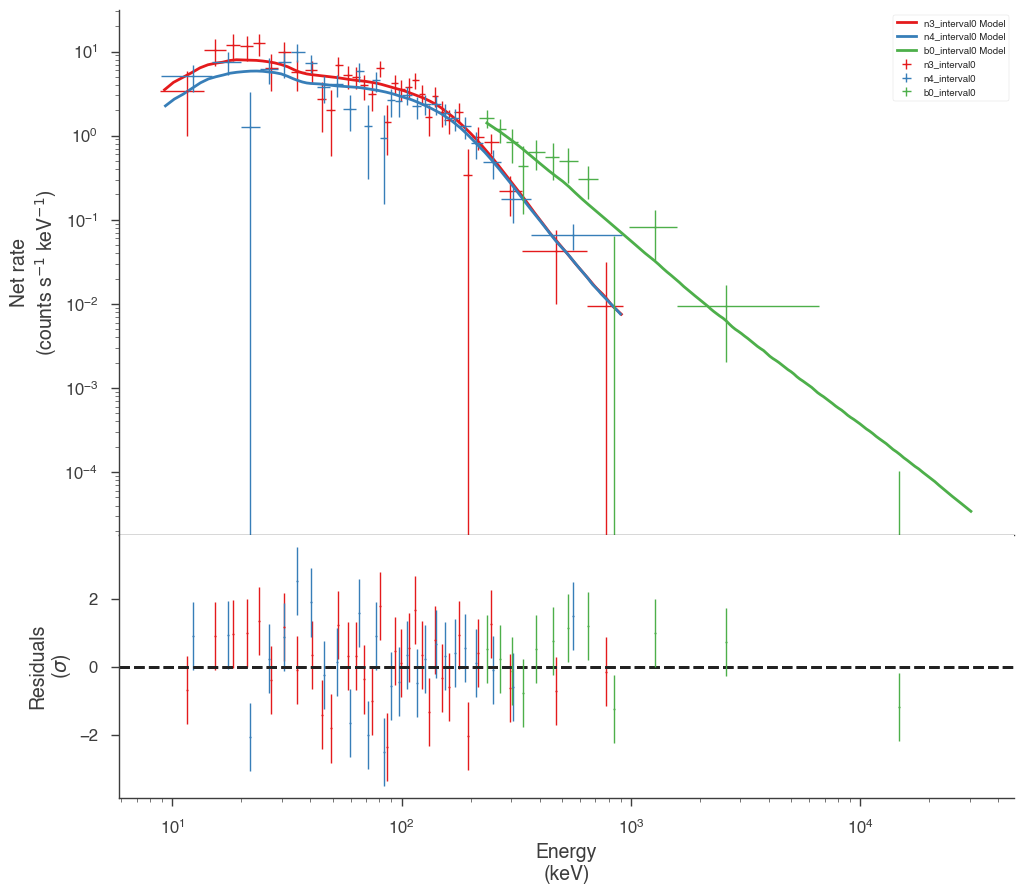

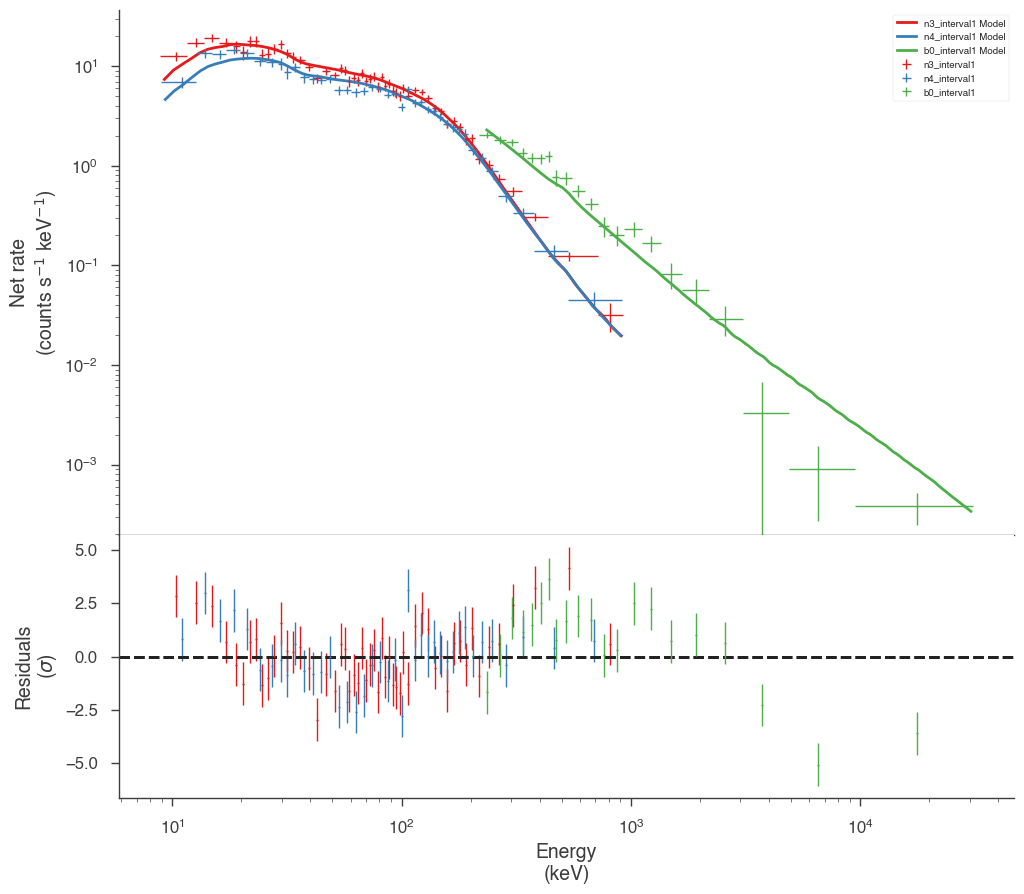

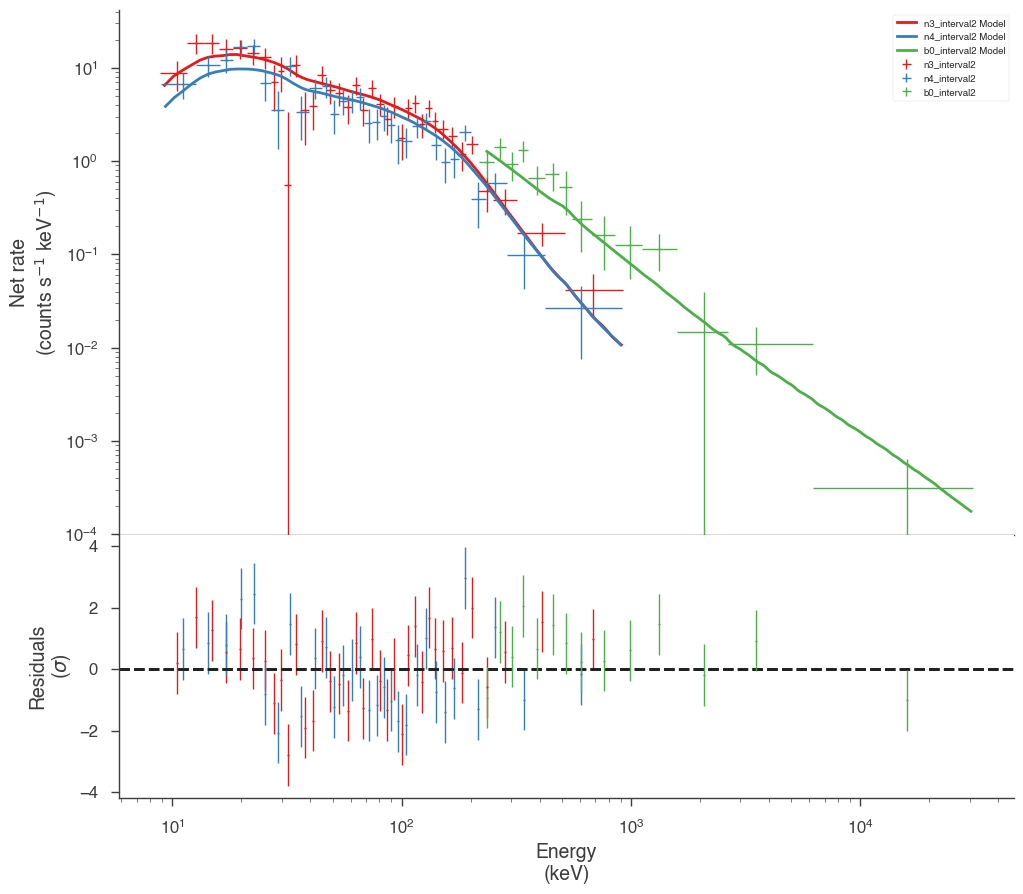

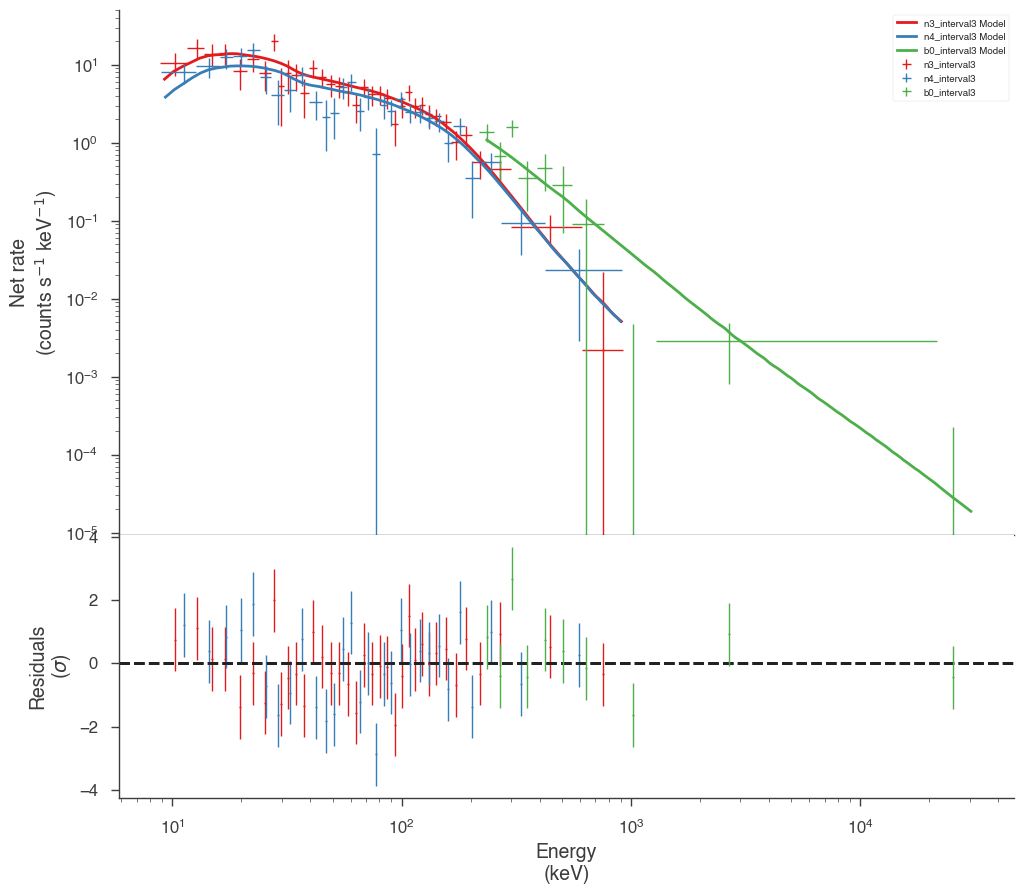

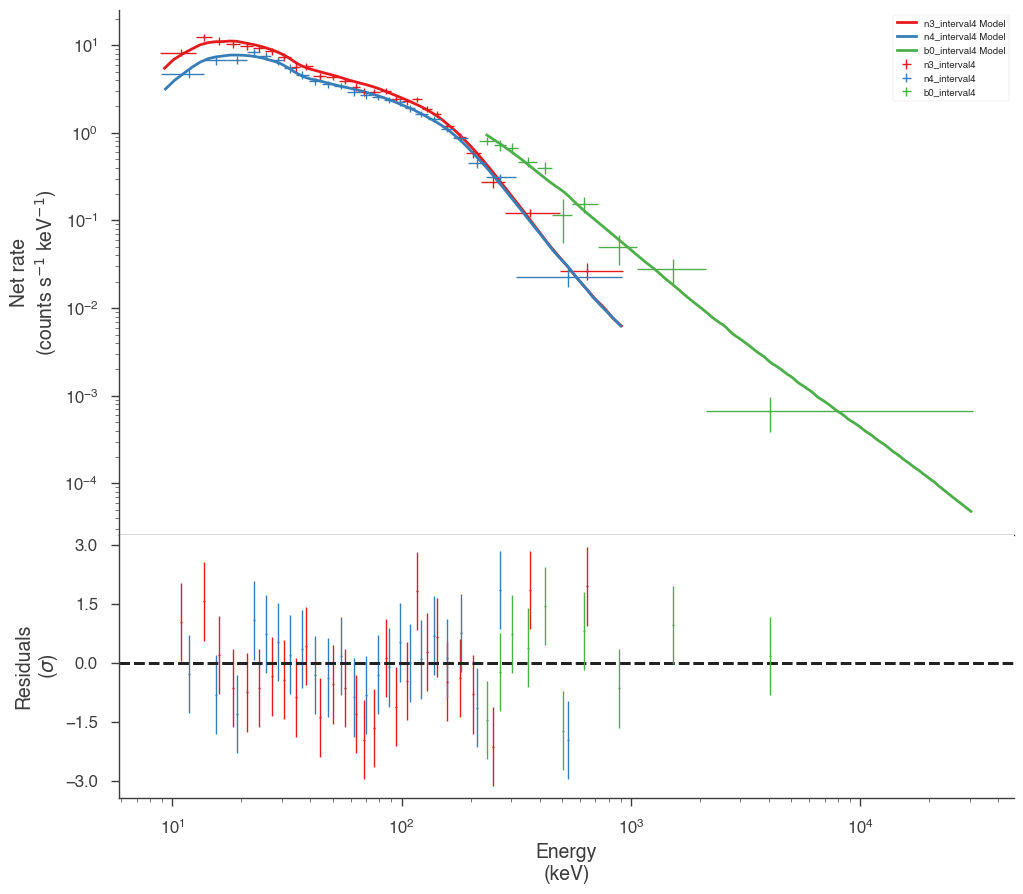

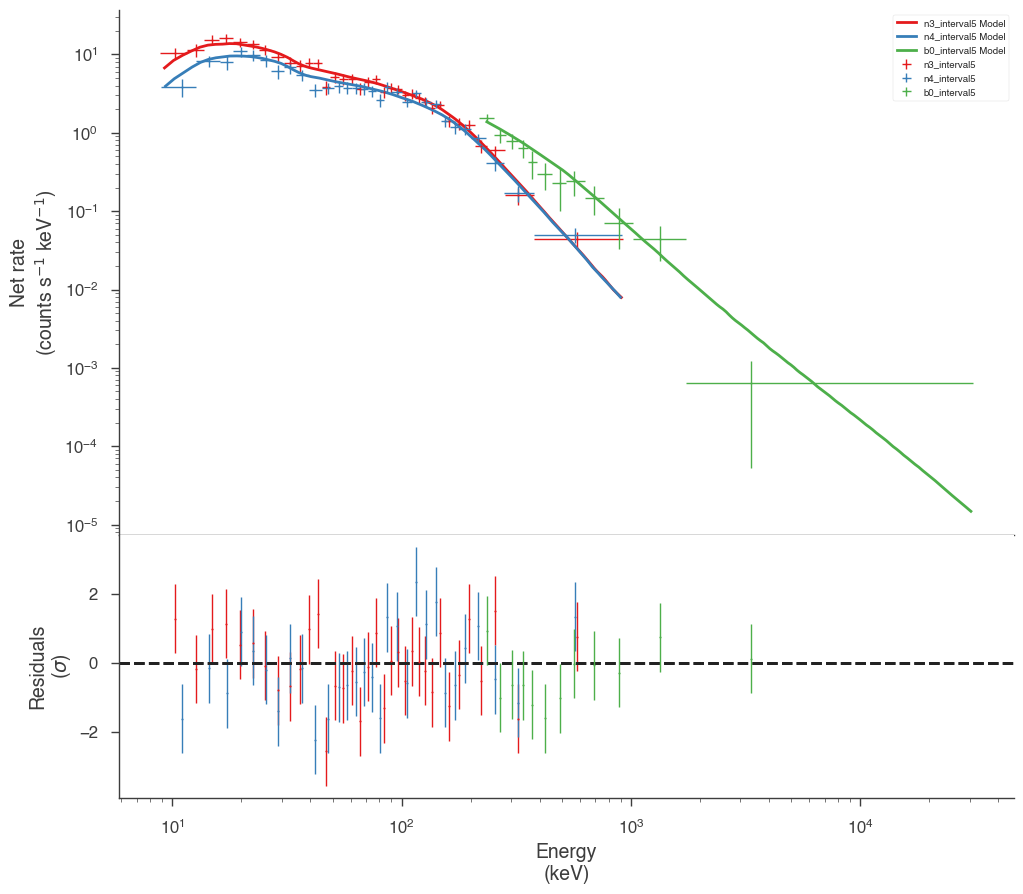

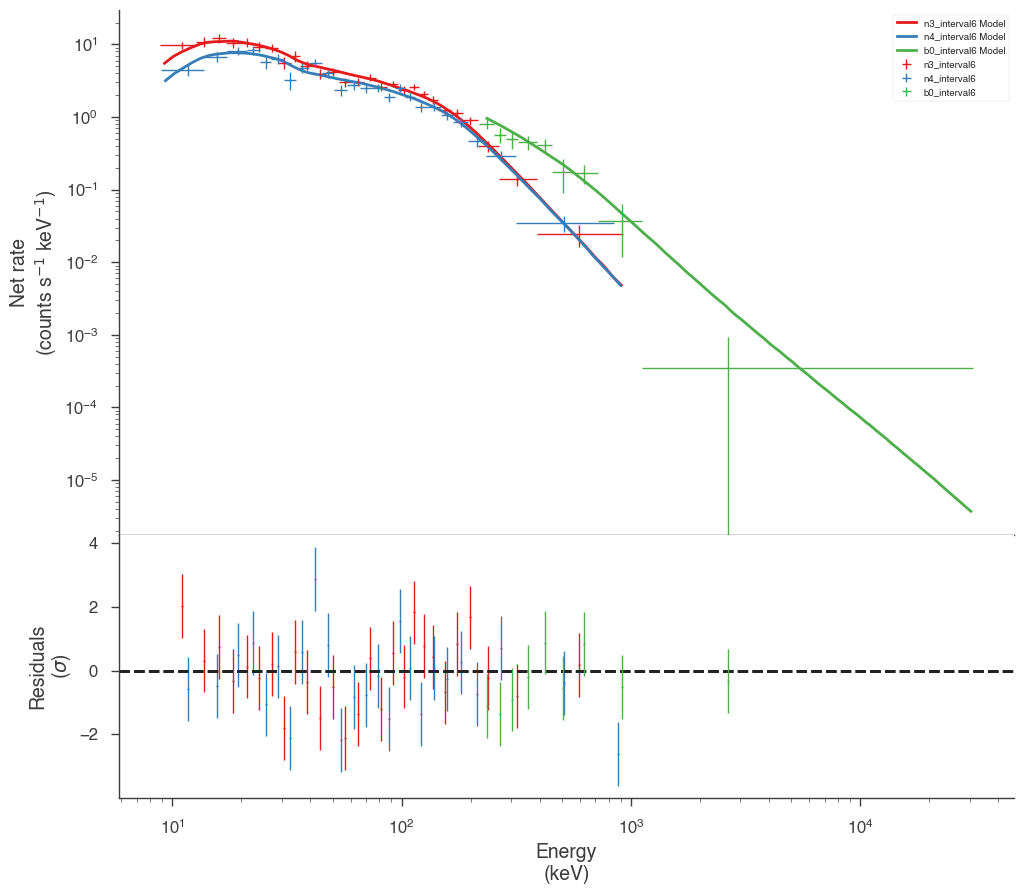

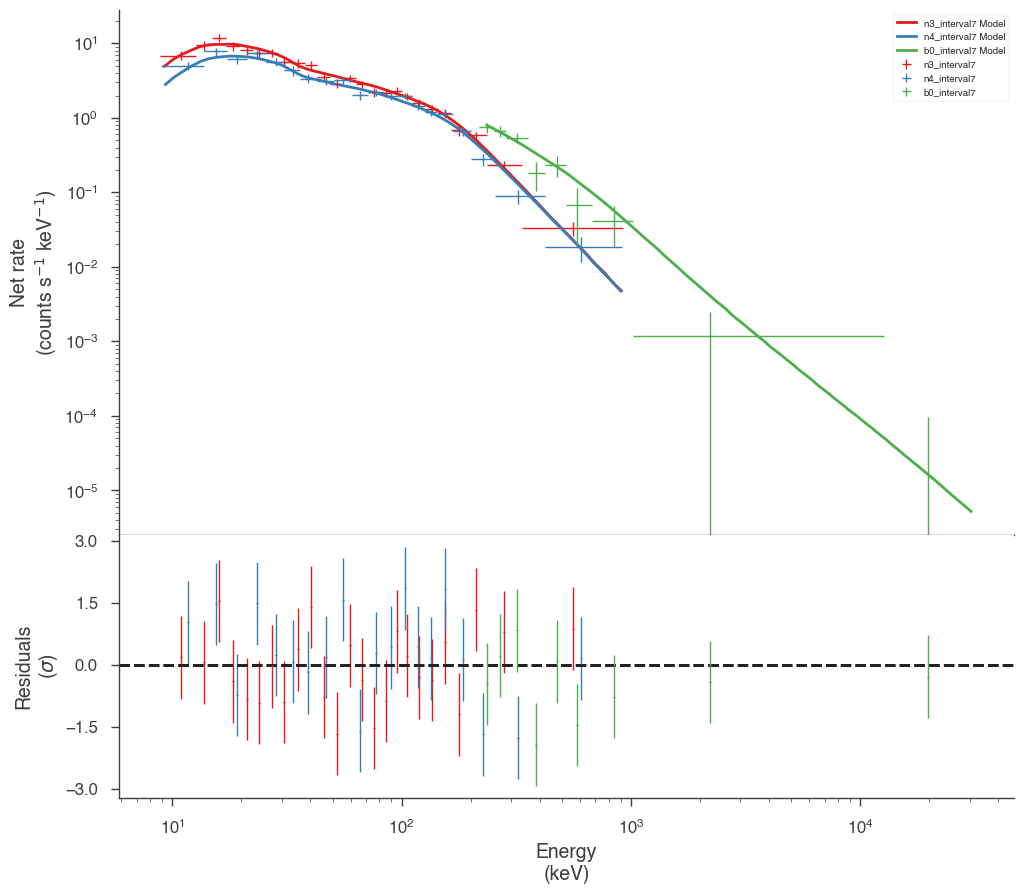

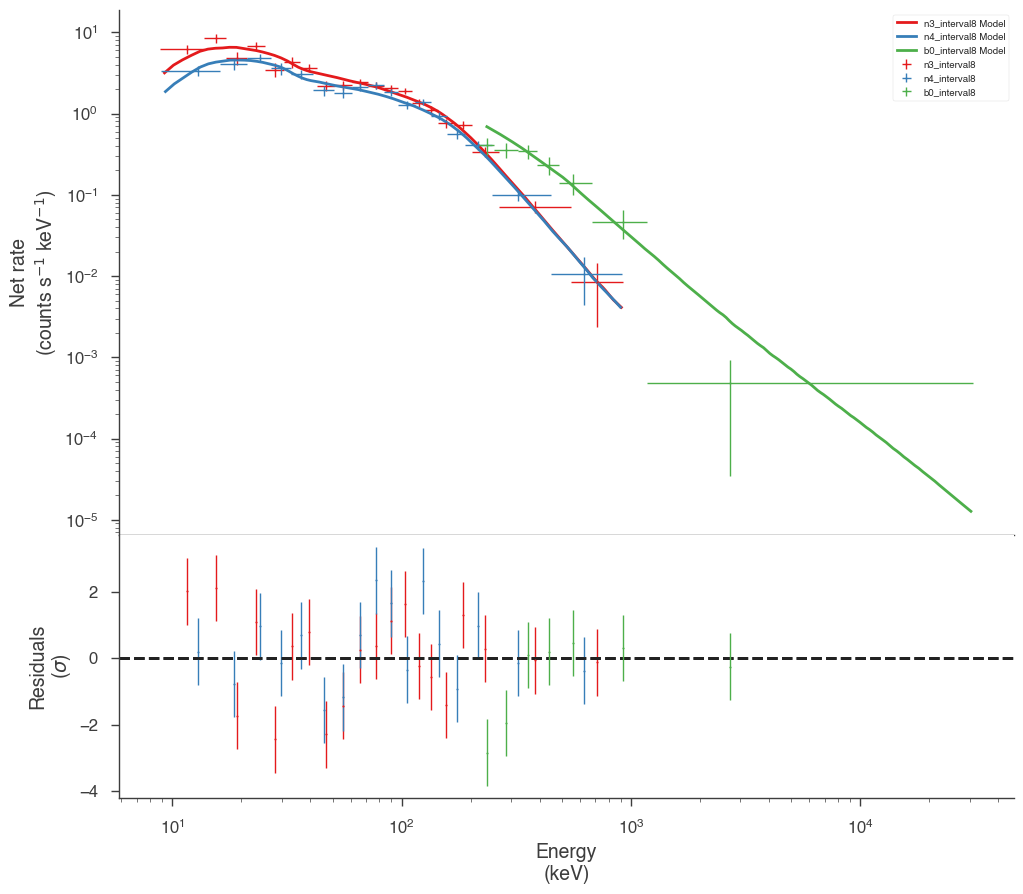

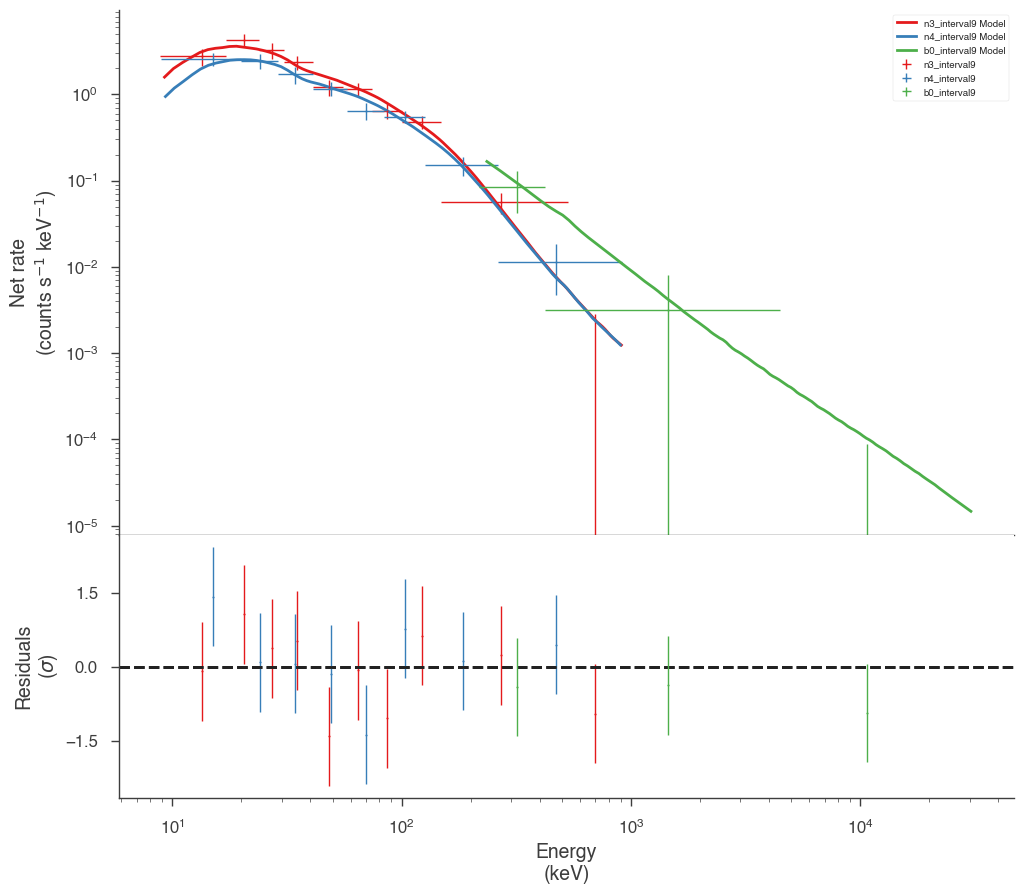

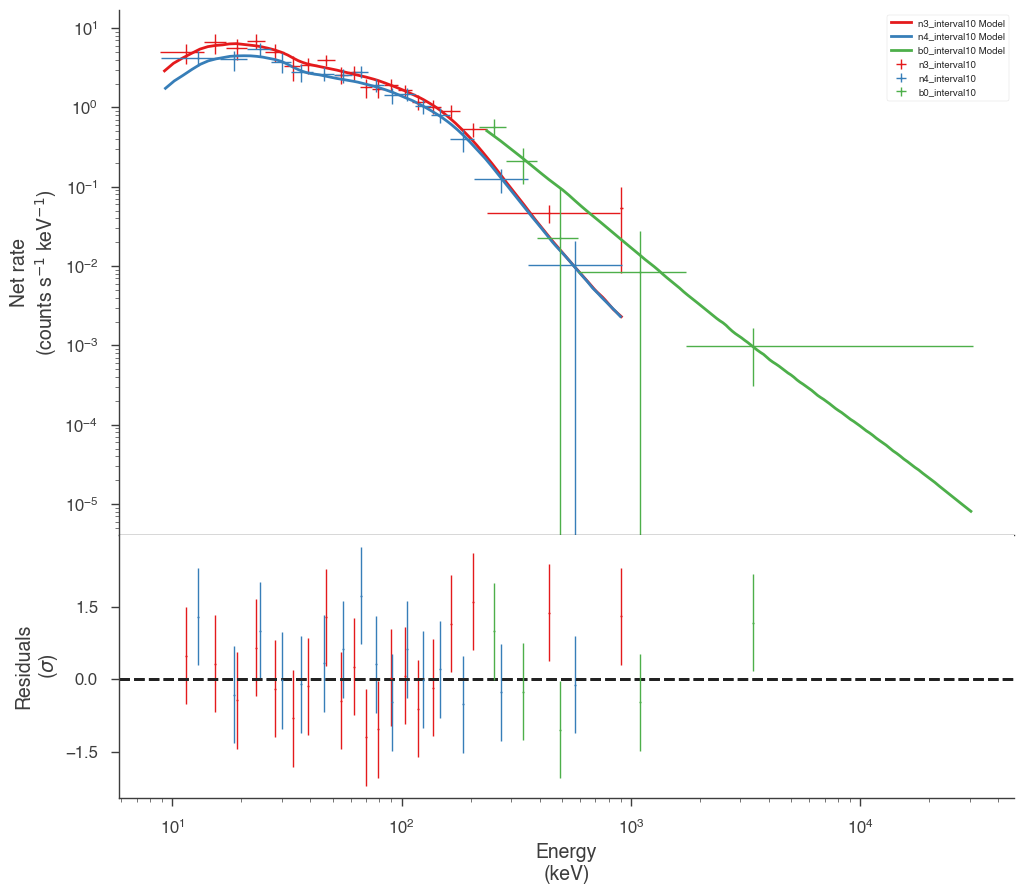

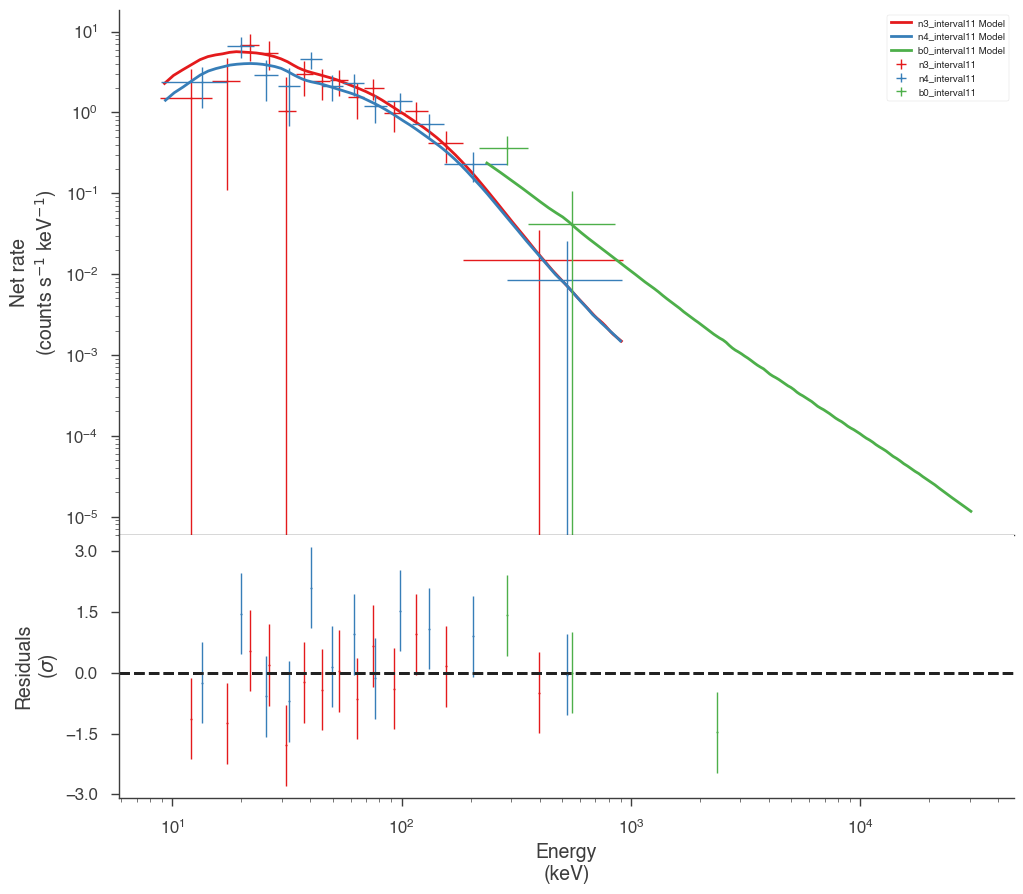

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

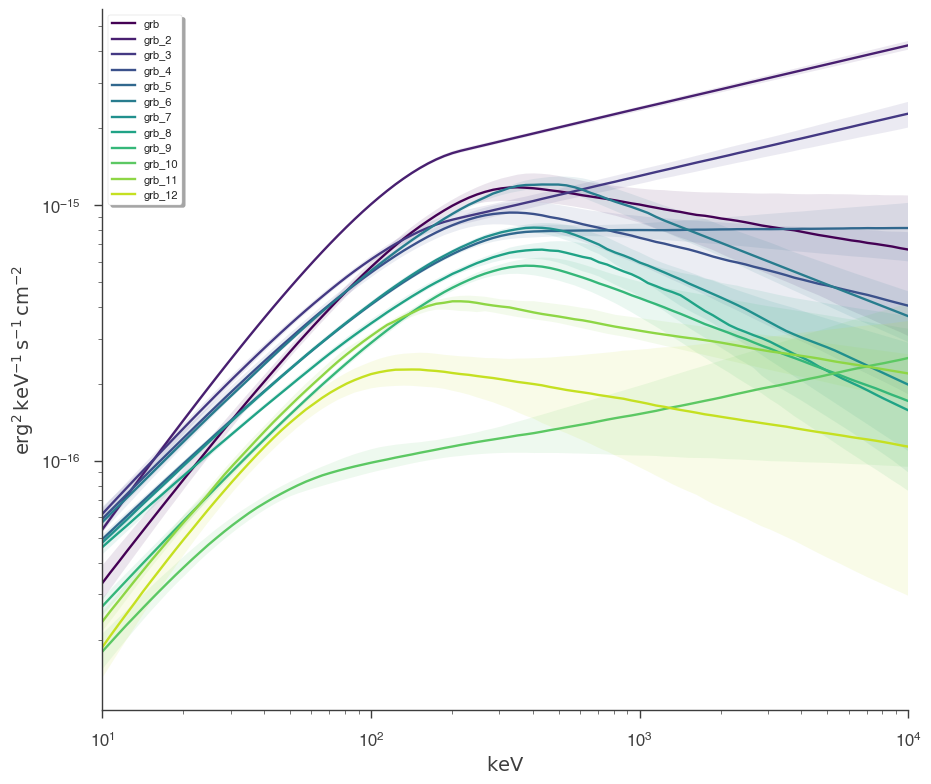

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.